# Locate peak on 2-D area detector image

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

TODO:

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Tue-21:59:04 - ############################################################ startup
I Tue-21:59:04 - logging started
I Tue-21:59:04 - logging level = 10
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Tue-21:59:04 - bluesky framework
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Tue-21:59:05 - /home/mi

work in progress



Transient Scan ID: 214     Time: 2021-02-23 22:02:19
Persistent Unique Scan ID: '65c2eb84-d542-4fec-8f59-b6673d127e7c'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 22:02:20.3 |
+-----------+------------+
generator count ['65c2eb84'] (scan num: 214)


('65c2eb84-d542-4fec-8f59-b6673d127e7c',)

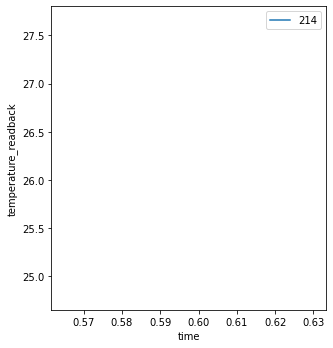

In [37]:
RE(bp.count([adsimdet]))

In [38]:
run = db.v2[-1]

In [39]:
run.metadata

{'start': Start({'beamline_id': 'APS_Python_training_2021',
 'detectors': ['adsimdet'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'instrument_name': 'class_2021_03',
 'login_id': 'mintadmin@mint-vm',
 'num_intervals': 0,
 'num_points': 1,
 'pid': 9931,
 'plan_args': {'detectors': ["MySimDetector(prefix='ad:', name='adsimdet', "
                             "read_attrs=[], configuration_attrs=['cam', "
                             "'cam.acquire_period', 'cam.acquire_time', "
                             "'cam.image_mode', 'cam.manufacturer', "
                             "'cam.model', 'cam.num_exposures', "
                             "'cam.num_images', 'cam.trigger_mode'])"],
               'num': 1},
 'plan_name': 'count',
 'plan_type': 'generator',
 'proposal_id': 'training',
 'scan_id': 214,
 'time': 1614139339.3187203,
 'uid': '65c2eb84-d542-4fec-8f59-b6673d127e7c',
 'versions': {'apstools': '1.4.0+1.g50c6f9d',
              'bluesky': '1.6.7',
              'databroker

In [40]:
# TODO: https://blueskyproject.io/databroker/tutorials/get-data.html?highlight=image
ds = run.primary.to_dask()

In [41]:
# FIXME: Where is the image data?
ds

<xarray.Dataset>
Dimensions:                               (time: 1)
Coordinates:
  * time                                  (time) float64 1.614e+09
Data variables:
    adsimdet:adsimdet_cam_acquire_period  (time) float64 0.105
    adsimdet:adsimdet_cam_acquire_time    (time) float64 0.1
    adsimdet:adsimdet_cam_image_mode      (time) int64 0
    adsimdet:adsimdet_cam_manufacturer    (time) <U18 'Simulated detector'
    adsimdet:adsimdet_cam_model           (time) <U15 'Basic simulator'
    adsimdet:adsimdet_cam_num_exposures   (time) int64 1
    adsimdet:adsimdet_cam_num_images      (time) int64 1
    adsimdet:adsimdet_cam_trigger_mode    (time) int64 0
    seq_num                               (time) int64 1
    uid                                   (time) <U36 '5b21fa04-92aa-4a65-a4f...

In [42]:
ds = run.primary.read()
ds

<xarray.Dataset>
Dimensions:                               (time: 1)
Coordinates:
  * time                                  (time) float64 1.614e+09
Data variables:
    adsimdet:adsimdet_cam_acquire_period  (time) float64 0.105
    adsimdet:adsimdet_cam_acquire_time    (time) float64 0.1
    adsimdet:adsimdet_cam_image_mode      (time) int64 0
    adsimdet:adsimdet_cam_manufacturer    (time) <U18 'Simulated detector'
    adsimdet:adsimdet_cam_model           (time) <U15 'Basic simulator'
    adsimdet:adsimdet_cam_num_exposures   (time) int64 1
    adsimdet:adsimdet_cam_num_images      (time) int64 1
    adsimdet:adsimdet_cam_trigger_mode    (time) int64 0
    seq_num                               (time) int64 1
    uid                                   (time) <U36 '5b21fa04-92aa-4a65-a4f...

----

---

[`%mov`](https://blueskyproject.io/bluesky/magics.html?highlight=label#moving-a-motor) (Magic command) : move a positioner